In [1]:
from optbinning import OptimalBinning


from os import listdir
from os.path import isfile, join
from datetime import datetime, timedelta
import time
import sys

import pandas as pd
import numpy as np
import random

from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from optbinning import OptimalBinning
from catboost import CatBoostClassifier, Pool, cv

import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from bayes_opt import BayesianOptimization
import catboost
import pickle
import csv
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve

In [2]:
#import importlib
from  evaluation_tools import prediccion as pre
#import evaluation_tools as ev
#importlib.reload(ev)
    

In [3]:
#from importlib.abc import Loader
#isinstance(Loader, spec.loader)

__Read data__


In [4]:

i = 'df_encod.csv'
df = pd.read_csv(i, sep=',', low_memory=False, error_bad_lines=False)
    


### Prepare data to train

In [5]:
df_types = df.dtypes


In [6]:
## Try model with original variables
## Try model with orginal + categorized variables according to opt binning
## Try model with orinal + categorized + encoded variables


__Define types for some variables__

In [7]:
categorical_cols = df_types[df_types=='object']
categorical_cols = list(categorical_cols.index)
categorical_cols = [x for x in categorical_cols if x!='id']
print(categorical_cols)



[]


In [8]:
for col in [col for col in df.columns if 'cat' in col]:
    df = df.drop(col, axis=1)
    
for col in categorical_cols:
    df = df.drop(col, axis=1)
    
df_types = df.dtypes

In [9]:
df_types = df.dtypes
df_view = df.copy()

In [10]:
numerical_cols = df_types[df_types!='object']
numerical_cols = list(numerical_cols.index)
numerical_cols = [x for x in numerical_cols if x!='default']
numerical_cols = [x for x in numerical_cols if x!='flag_train']

#numerical_cols = list(set(numerical_cols)-set(ordinal_cols))
numerical_cols = list(set(numerical_cols)-set(categorical_cols)- set('random'))
categorical_cols=[]

__Prepare object to train__

In [11]:
#print(categorical_cols)
predictors = numerical_cols + categorical_cols 
end_num = len(numerical_cols)
end_cat = len(predictors)

In [12]:

l=predictors.copy()
l.extend(['default', 'flag_train'])
#print(l)

for x in categorical_cols:
    df_view[x] = df_view[x].astype(str)

df_view2 = df_view[l].copy()

cat_features = [df_view2.columns.get_loc(c) for c in categorical_cols  if c in df_view2]
cat_features

[]

In [13]:

X_train = df_view2[(df_view2['flag_train'] ==0)]
y_train = X_train.pop('default')

X_val = df_view2[(df_view2['flag_train'] ==1)]
y_val = X_val.pop('default')

X_test = df_view2[(df_view2['flag_train'] ==2)]
y_test = X_test.pop('default')

x_train = X_train[predictors].values

### Train

__Save model and some parameters__

__Load model from files__

In [14]:
pkl_filename = "model2.pkl"
with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)

with open('predictors2.csv', newline='') as f:
        reader = csv.reader(f)
        predictors = list(reader)[0]

with open('to_cat2.csv', newline='') as f:
        reader = csv.reader(f)
        categorical_cols = list(reader)[0]

### Test model

In [15]:
y_pred_probs= model.predict_proba(df_view[predictors].values)
df_view['pred']=[item[1] for item in y_pred_probs]

In [16]:


for pob in [0,1,2]:
    print(pob)
    X_ = df_view[(df_view['flag_train'] ==pob)].copy()

    pred_def = X_.loc[(X_['default']==1), 'pred']
    pred_Ndef =X_.loc[(X_['default']==0), 'pred']
    ks=stats.ks_2samp(pred_def, pred_Ndef)
    print(ks)            

    print('AUC: '+str(np.round(roc_auc_score(X_.default,  X_.pred)  ,2)))

    #skplt.metrics.plot_ks_statistic( (X_.default.to_list()) , [ (1-x, x) for x in X_.pred])
    #plt.show()

    #skplt.metrics.plot_precision_recall_curve(X_.default.to_list(), [ (1-x, x) for x in X_.pred])
    #plt.show()

0
KstestResult(statistic=0.6670836943256392, pvalue=0.0)
AUC: 0.92
1
KstestResult(statistic=0.6434794247429899, pvalue=5.535074544563141e-105)
AUC: 0.89
2
KstestResult(statistic=0.6423131240509785, pvalue=1.55891988757182e-100)
AUC: 0.89


In [17]:
df_view['id'] = df['id']

In [18]:
#pip install git+git://github.com/gabriela-plantie/evaluation_tools

p = pre.Predictor(df_view[df_view.flag_train==2], 'id', 'pred', 'default')
p.performance_table(q_group=[100,200,300,500,1000])

mean: 0.014077453817048743
events: 253.0


(                      id  default  default_rate  pc_pob  pc_default  lift
 pred_cut                                                                 
 (-0.001, 0.00156]   1798      0.0         0.000    0.10        0.00   0.0
 (0.00156, 0.00207]  1797      1.0         0.001    0.10        0.00   0.1
 (0.00207, 0.00289]  1797      2.0         0.001    0.10        0.01   0.1
 (0.00289, 0.00395]  1797      1.0         0.001    0.10        0.00   0.1
 (0.00395, 0.0054]   1797      3.0         0.002    0.10        0.01   0.1
 (0.0054, 0.00796]   1797      4.0         0.002    0.10        0.02   0.1
 (0.00796, 0.0123]   1797      9.0         0.005    0.10        0.04   0.4
 (0.0123, 0.0174]    1797     29.0         0.016    0.10        0.11   1.1
 (0.0174, 0.0243]    1495     38.0         0.025    0.08        0.15   1.8
 (0.0243, 0.0272]     302     12.0         0.040    0.02        0.05   2.8
 (0.0272, 0.0384]     698     32.0         0.046    0.04        0.13   3.3
 (0.0384, 0.0575]     500

KstestResult(statistic=0.6423131240509785, pvalue=1.55891988757182e-100)
mean: 0.014077453817048743
events: 253.0


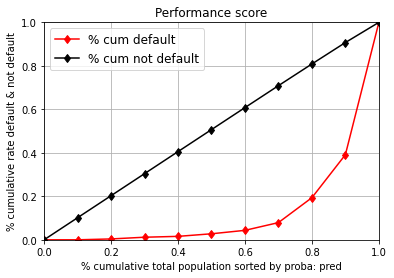

In [19]:
p.graph_ks()

mean: 0.014077453817048743
events: 253.0


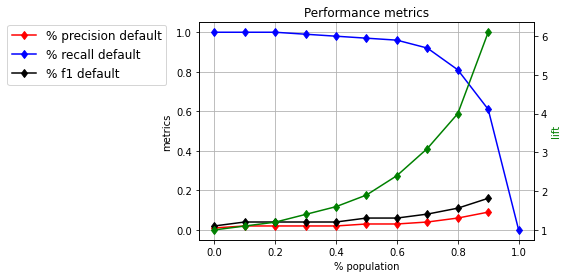

In [20]:
p.graph_others()

<AxesSubplot:xlabel='0'>

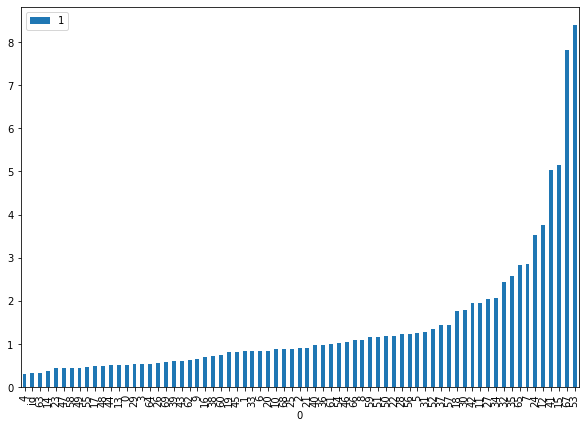

In [21]:
imp = pd.DataFrame(list(zip(predictors, list(model.get_feature_importance()))))
imp = imp.set_index(0)
imp = imp.sort_values(1)
imp.plot.bar(figsize=(10,7))